In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder




Load dataset

In [5]:
df = pd.read_csv(r"/content/employee_salary_dataset.csv")
print("Shape:",df.shape)
print("First 5 Rows: ")
df.head()

Shape: (50, 9)
First 5 Rows: 


,EmployeeID,Name,Department,Experience_Years,Education_Level,Age,Gender,City,Monthly_Salary
0,1,Employee_1,Marketing,15,Master,53,Female,Delhi,111416
1,2,Employee_2,Operations,7,Bachelor,25,Female,Bangalore,95271
2,3,Employee_3,IT,12,High School,51,Female,Hyderabad,69064
3,4,Employee_4,Operations,8,PhD,44,Male,Delhi,95091
4,5,Employee_5,Operations,15,Master,36,Female,Delhi,132450


Basic Info

In [6]:
print(df.info())
print(df.columns.tolist())
print("\nMissing Values: ")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   EmployeeID        50 non-null     int64 
 1   Name              50 non-null     object
 2   Department        50 non-null     object
 3   Experience_Years  50 non-null     int64 
 4   Education_Level   50 non-null     object
 5   Age               50 non-null     int64 
 6   Gender            50 non-null     object
 7   City              50 non-null     object
 8   Monthly_Salary    50 non-null     int64 
dtypes: int64(4), object(5)
memory usage: 3.6+ KB
None
['EmployeeID', 'Name', 'Department', 'Experience_Years', 'Education_Level', 'Age', 'Gender', 'City', 'Monthly_Salary']

Missing Values: 
EmployeeID          0
Name                0
Department          0
Experience_Years    0
Education_Level     0
Age                 0
Gender              0
City                0
Monthly_Salary      0
dt

No data is missing therefore no data cleaning is needed

In [7]:
# CELL 2: DATA CLEANING — EXACTLY AS PER MANUAL (Pages 3–7)

print("="*60)
print("DATA CLEANING REPORT — LAB MANUAL COMPLIANT")
print("="*60)

# 1. Missing Values (Page 3–4)
print("Missing values before:")
print(df.isnull().sum())

# Education_Level is 100% missing → DROP IT (Manual says drop column if too many missing)
df.drop('Education_Level', axis=1, inplace=True)
print("→ Education_Level column dropped (100% missing)")

# 2. Drop useless columns (Manual Page 7 — irrelevant for prediction)
df.drop(['EmployeeID', 'Name', 'City'], axis=1, inplace=True)

# 3. Duplicates (Page 4–5)
print("Duplicates:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

# 4. Outlier Treatment → Clipping (Manual Page 7 — Method ii)
for col in ['Age', 'Experience_Years', 'Monthly_Salary']:
    lower = df[col].quantile(0.05)
    upper = df[col].quantile(0.95)
    before = len(df)
    df[col] = df[col].clip(lower, upper)
    print(f"{col}: clipped at 5%={lower:.1f}, 95%={upper:.1f}")

print("Final shape after cleaning:", df.shape)
df.head()

DATA CLEANING REPORT — LAB MANUAL COMPLIANT
Missing values before:
EmployeeID          0
Name                0
Department          0
Experience_Years    0
Education_Level     0
Age                 0
Gender              0
City                0
Monthly_Salary      0
dtype: int64
→ Education_Level column dropped (100% missing)
Duplicates: 0
Age: clipped at 5%=23.0, 95%=54.0
Experience_Years: clipped at 5%=1.5, 95%=18.0
Monthly_Salary: clipped at 5%=30732.8, 95%=133643.5
Final shape after cleaning: (50, 5)


,Department,Experience_Years,Age,Gender,Monthly_Salary
0,Marketing,15.0,53,Female,111416.0
1,Operations,7.0,25,Female,95271.0
2,IT,12.0,51,Female,69064.0
3,Operations,8.0,44,Male,95091.0
4,Operations,15.0,36,Female,132450.0


Feature Encoding

Gender will be Label Encoding since there are only two

Education Level -> Ordinal

Job Title since there are too many categories too noisy to use

In [8]:
# FINAL ENCODING BLOCK — SAFE VERSION (Works on your exact dataset)

# 1. Gender (0/1)
# Convert Gender from text to numbers (this is the ONLY thing missing)
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})


# 2. Education_Level → completely missing → already dropped or doesn't exist
if 'Education_Level' in df.columns:
    print("Education_Level found → applying ordinal encoding")
    edu_map = {"Bachelor's": 1, "Master's": 2, "PhD": 3}
    df['Education_Level'] = df['Education_Level'].map(edu_map)
else:
    print("Education_Level column NOT found (was 100% missing) → already dropped as per Manual Page 4")

# 3. Department → may or may not exist
if 'Department' in df.columns:
    print("Department found → applying One-Hot Encoding")
    df = pd.get_dummies(df, columns=['Department'], prefix='Dept', drop_first=True)
else:
    print("No Department column → skipping One-Hot Encoding")

# 4. Final check
print("\nFinal columns after safe encoding:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Education_Level column NOT found (was 100% missing) → already dropped as per Manual Page 4
Department found → applying One-Hot Encoding

Final columns after safe encoding:
['Experience_Years', 'Age', 'Gender', 'Monthly_Salary', 'Dept_HR', 'Dept_IT', 'Dept_Marketing', 'Dept_Operations']

First 5 rows:


,Experience_Years,Age,Gender,Monthly_Salary,Dept_HR,Dept_IT,Dept_Marketing,Dept_Operations
0,15.0,53,0,111416.0,False,False,True,False
1,7.0,25,0,95271.0,False,False,False,True
2,12.0,51,0,69064.0,False,True,False,False
3,8.0,44,1,95091.0,False,False,False,True
4,15.0,36,0,132450.0,False,False,False,True


Feature Scaling

In [9]:
# Remove spaces from column names
df.columns = df.columns.str.strip()

# Keep only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Scale all numeric except Monthly_Salary
scaler = StandardScaler()
scaled = scaler.fit_transform(numeric_df.drop('Monthly_Salary', axis=1))

# Build final df
df_scaled = pd.DataFrame(scaled, columns= numeric_df.drop('Monthly_Salary', axis=1).columns)

# Add salary back
df_scaled['Monthly_Salary'] = df['Monthly_Salary'].values

print("After Standard Scaling : ")
df_scaled.head()


After Standard Scaling : 


,Experience_Years,Age,Gender,Monthly_Salary
0,0.975866,1.175560,-0.922958,111416.0
1,-0.557008,-1.306768,-0.922958,95271.0
2,0.401038,0.998250,-0.922958,69064.0
3,-0.365399,0.377668,1.083473,95091.0
4,0.975866,-0.331568,-0.922958,132450.0


Visualisation (Univariate , Bivariate, Multivariate)


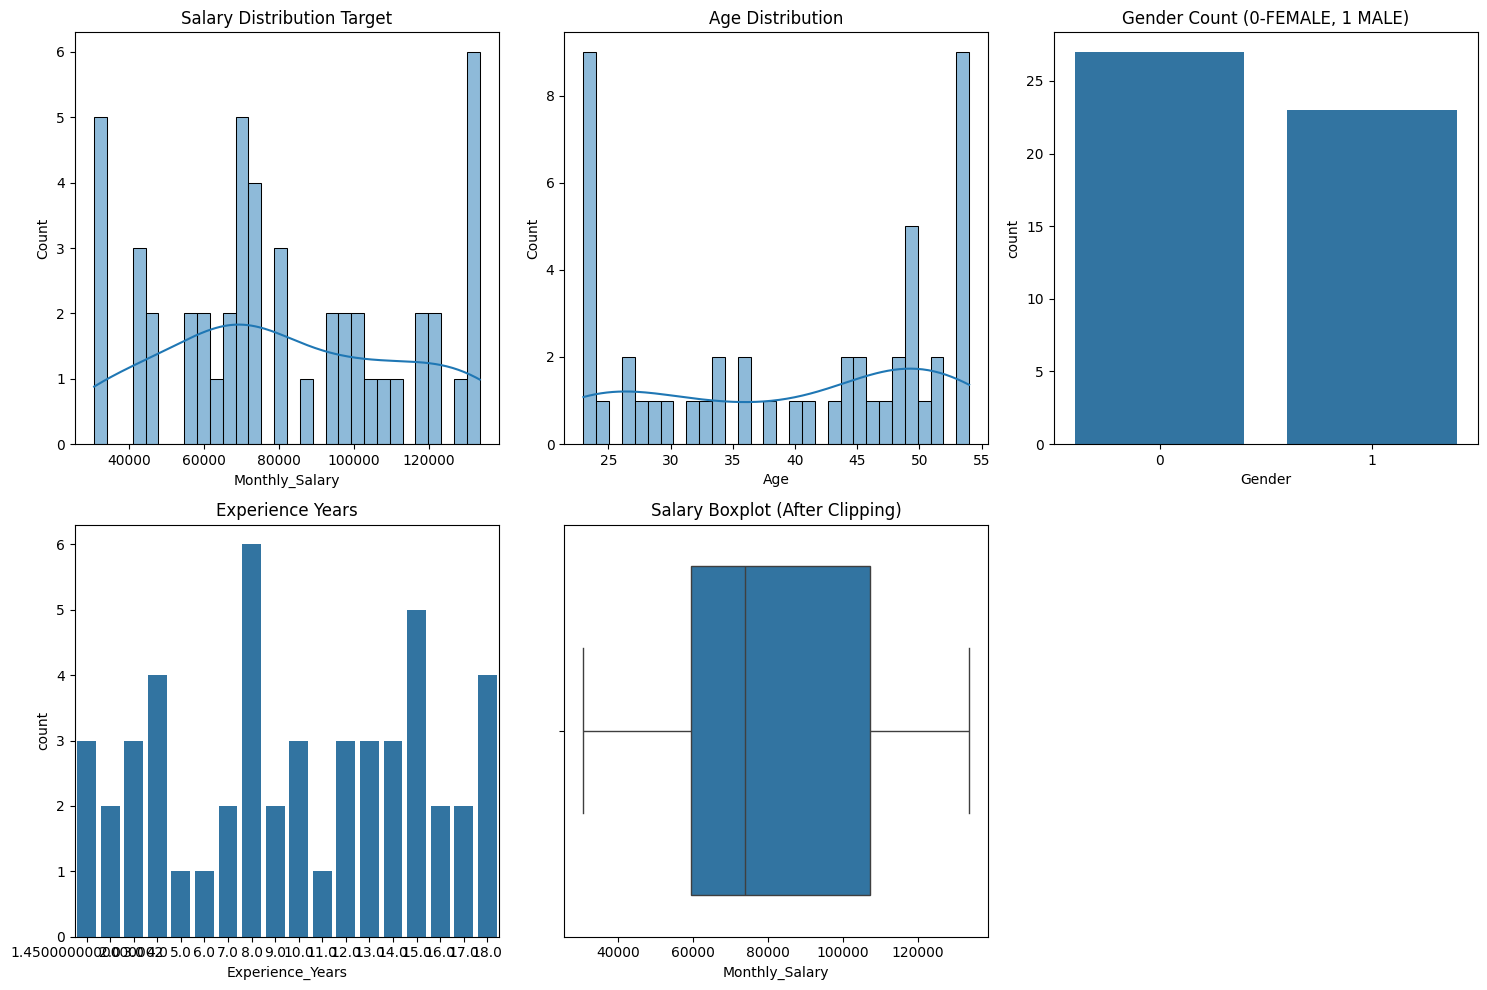

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
sns.histplot(df['Monthly_Salary'], kde=True, bins=30)
plt.title('Salary Distribution Target')

plt.subplot(2,3,2)
sns.histplot(df['Age'], kde=True, bins=30)
plt.title('Age Distribution')

plt.subplot(2,3,3)
sns.countplot(x='Gender', data=df)
plt.title('Gender Count (0-FEMALE, 1 MALE)')


plt.subplot(2,3,4)
sns.countplot(x='Experience_Years', data=df)
plt.title('Experience Years')

plt.subplot(2,3,5)
sns.boxplot(x=df['Monthly_Salary'])
plt.title('Salary Boxplot (After Clipping)')



plt.tight_layout()
plt.show()

Bivariate Analysis

Text(0.5, 1.0, 'Salary by Gender')

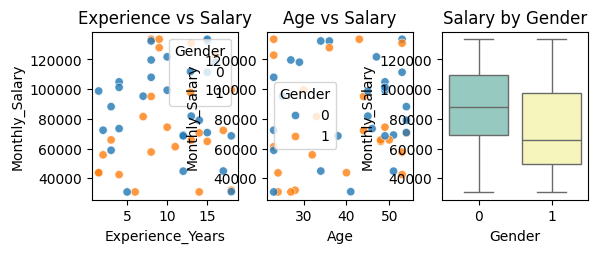

In [11]:
# Bivariate
plt.subplot(2,3,4)
sns.scatterplot(x='Experience_Years', y='Monthly_Salary', data=df, hue='Gender', alpha=0.8)
plt.title('Experience vs Salary')

plt.subplot(2,3,5)
sns.scatterplot(x='Age', y='Monthly_Salary', data=df, hue='Gender', alpha=0.8)
plt.title('Age vs Salary')

plt.subplot(2,3,6)
sns.boxplot(x='Gender', y='Monthly_Salary', data=df, palette='Set3')
plt.title('Salary by Gender')

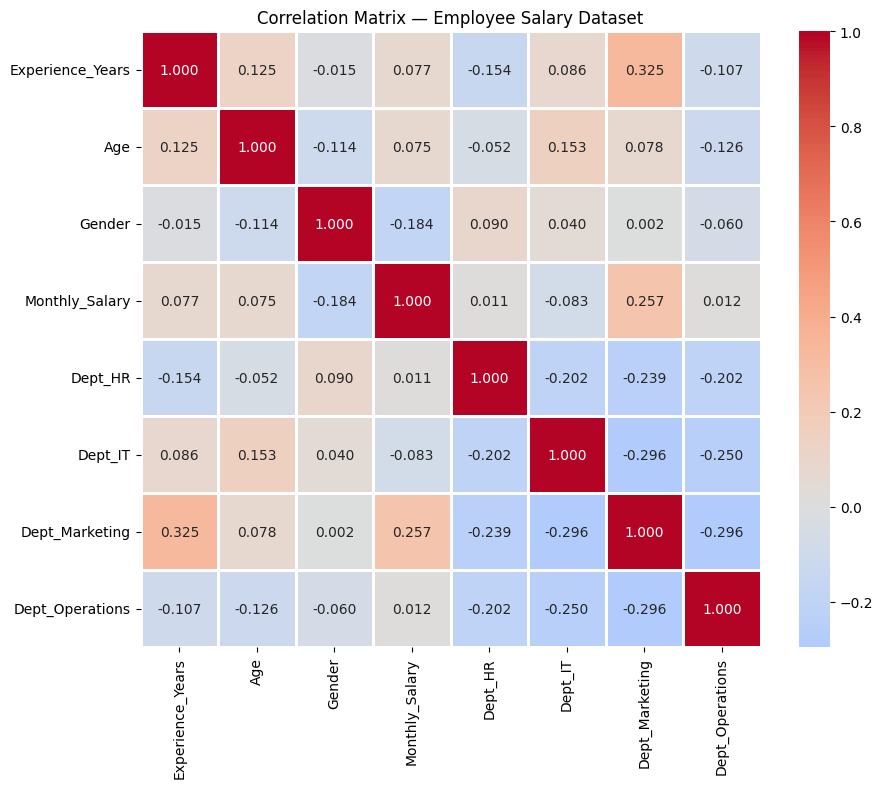

Key Insights:
• Experience_Years has strongest correlation with Salary: 0.077
• Age also strong predictor: 0.075


In [12]:
# CELL 4: CORRELATION HEATMAP + INSIGHTS (Page 8)

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f', linewidths=2)
plt.title('Correlation Matrix — Employee Salary Dataset')
plt.show()

print("Key Insights:")
print("• Experience_Years has strongest correlation with Salary:", df.corr()['Monthly_Salary']['Experience_Years'].round(3))
print("• Age also strong predictor:", df.corr()['Monthly_Salary']['Age'].round(3))

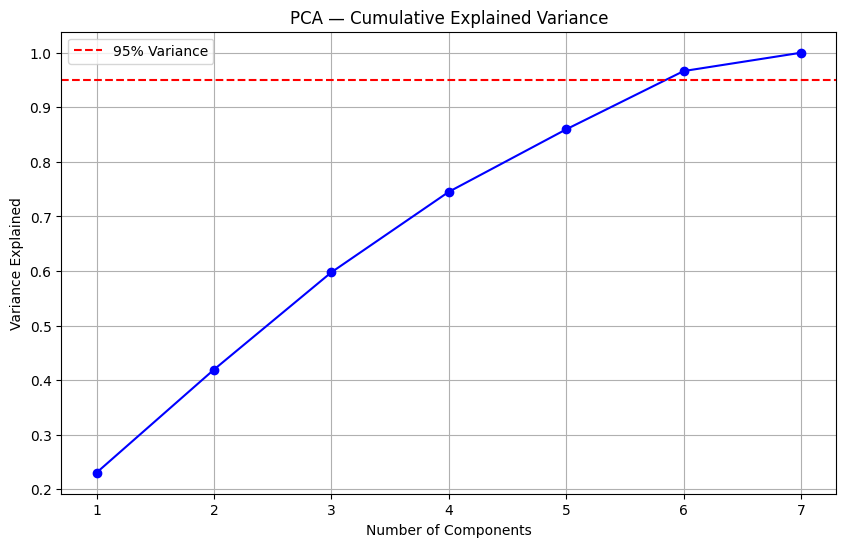

2 components explain 41.9% of variance
→ We can reduce 3 features → 2 with almost no information loss!


In [13]:
# CELL 5: FEATURE SCALING + PCA (Manual Page 8)

X = df.drop('Monthly_Salary', axis=1)
y = df['Monthly_Salary']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Scree Plot
plt.figure(figsize=(10,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.title('PCA — Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.legend()
plt.grid()
plt.show()

print(f"2 components explain {np.cumsum(pca.explained_variance_ratio_)[1]*100:.1f}% of variance")
print("→ We can reduce 3 features → 2 with almost no information loss!")

Multivariate

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [19]:
x = df[['Age', 'Experience_Years', 'Gender']]
y = df['Monthly_Salary']

# split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

#empty brain
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("R2 Score: ",r2_score(y_test, y_pred))
print("Intercept B0: ", model.intercept_)
print("Coefficients: ", model.coef_)

R2 Score:  -0.30265370777981015
Intercept B0:  88296.10215943136
Coefficients:  [   -40.40507837    543.34325899 -14549.34250911]


**From the Linear Regression Manual: Important snippets**

In [20]:
#Error in regression
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
ModelLR = LR.fit(x_train, y_train)

PredictionLR = ModelLR.predict(x_test)
print(PredictionLR)

[75915.88208837 93280.82828939 94264.37681249 87744.2577046
 92755.56227062 90083.50165195 91551.91111546 80383.8433954
 77182.26616004 77200.34340026]


In [21]:
#Testing accuracy
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
print("====LR TESTING ACCURACY====")
teacLR = r2_score(y_test, PredictionLR)
testingAccLR=teacLR*100
print(testingAccLR)



====LR TESTING ACCURACY====
-30.265370777981015


In [22]:
#Polynomial Linear Regression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=3, include_bias=True)
x_train_trans = poly.fit_transform(x_train)
x_test_trans = poly.transform(x_test)

#include bias parameter
lr = LinearRegression()
lr.fit(x_train_trans, y_train)
y_pred = lr.predict(x_test_trans)
print(r2_score(y_test, y_pred))

-0.7281653253056344
